In [1]:
import qiskit
import numpy as np

import json, glob, math

In [2]:
glob.glob("*")

['classicalFT.py',
 'CPixel_demo.py',
 'CVector_demo.py',
 'elephant QFT-Copy1.ipynb',
 'elephant QFT.ipynb',
 'LICENSE.md',
 'output',
 'plotTools.py',
 'pngTools.py',
 'presentation source',
 'QHOMER_IQFT.ipynb',
 'QHOMER_Optimizer_Function_FIXED-Copy1.ipynb',
 'QHOMER_Optimizer_Function_FIXED-Copy2.ipynb',
 'QHOMER_Optimizer_Function_FIXED.ipynb',
 'README.md',
 'Resources',
 'SVG_demo.py',
 'VectorQraphics.py',
 'vqe_analysis',
 '__pycache__']

In [3]:
def qubits_necessary(n):
    """log2 of n"""
    l2 = math.log2(n)
    assert l2 % 1 == 0, "not an integer power of 2"
    return int(l2)

def normalized(arr):
    """l2-normalization"""
    return arr / np.linalg.norm(arr, 2)

## Data Loading

In [81]:
with open("./Resources/homer.9.json") as f:
    data = json.load(f)[:-1]
    
    nextpowerof2 = 2**math.ceil(math.log2(len(data)))
    data = [*data, *((nextpowerof2-len(data))*[[0.,0.]])]
    
    data = normalized(np.array([complex(a, b) for a, b in data]))
    
    #data = np.round(data, 2)

In [82]:
data

array([0.03467397+0.05865302j, 0.04090114+0.0565255j ,
       0.04740511+0.05784197j, 0.05168185+0.06225712j,
       0.05437845+0.06788862j, 0.05404177+0.07446052j,
       0.05039188+0.07947104j, 0.04568359+0.0820019j ,
       0.03918417+0.08250662j, 0.03327113+0.07970575j,
       0.02981918+0.07456761j, 0.02854272+0.06812874j,
       0.03089154+0.06198996j, 0.07224398+0.06547671j,
       0.06822083+0.06341143j, 0.06317904+0.06279263j,
       0.05829662+0.06376351j, 0.0547058 +0.06653934j,
       0.05324415+0.07096146j, 0.05426601+0.07609313j,
       0.05755073+0.08034511j, 0.06233634+0.08218638j,
       0.06748733+0.08097405j, 0.07176754+0.0772901j ,
       0.07414962+0.07254113j, 0.07407236+0.06814922j,
       0.06217906+0.02698909j, 0.04672462+0.02912393j,
       0.0482156 +0.02920148j, 0.06303357+0.02731842j,
       0.0764541 +0.03181481j, 0.07344411+0.04569928j,
       0.06367207+0.05163087j, 0.04841738+0.05033987j,
       0.03564843+0.04390106j, 0.03102647+0.03061775j,
       0.0

## Classical FT

In [83]:
data_ft = normalized(np.fft.fft(data))

In [84]:
data_ft

array([ 3.16710018e-01+5.70006908e-01j,  4.34266978e-01-2.76626863e-01j,
       -1.05747338e-01-4.14192825e-02j,  1.59648553e-01-1.39158311e-02j,
       -4.03590223e-02-6.43488996e-02j,  5.24274240e-02+5.15928099e-02j,
        7.11777924e-02-1.68156134e-02j,  5.32101743e-02-5.61010204e-02j,
       -1.51824870e-02-3.73246967e-02j, -7.72175293e-05+5.78135165e-03j,
        2.56510746e-02+1.56614548e-02j,  2.99078025e-02-2.02732603e-02j,
        8.51749788e-03+7.53513075e-03j,  3.95318458e-02-5.09285141e-03j,
        2.93454811e-02-1.90479407e-02j,  1.42787778e-03-3.00525680e-02j,
        1.58896226e-02+2.24931293e-02j,  4.12385057e-02-4.20952219e-02j,
       -1.34785292e-02-7.38331742e-03j,  3.56765596e-02-2.03272337e-02j,
       -1.32064434e-02-3.08578791e-02j,  2.76314716e-03-9.44571461e-03j,
       -8.17883301e-03-1.87403471e-02j, -1.86359992e-02-6.45494741e-03j,
       -7.75268463e-03+2.48811526e-02j,  3.04251250e-02+2.43019003e-03j,
        6.67788413e-03-2.07368401e-02j, -4.76940794

## State Loading

In [85]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute

In [86]:
def to_statevector(self, config={}):
    job = execute(
        self,
        Aer.get_backend("statevector_simulator"),
        **config
    )
    return job.result().get_statevector()

QuantumCircuit.to_statevector = to_statevector

In [88]:
def QHomer_Init(data_ft):
    """creates an initialization circuit creating a state with data_ft as coefficients"""
    # number of qubits necessary
    qubit_count = qubits_necessary(len(data_ft))
    #print(f"need {qubit_count} qubits")

    # quantum and classical registers
    qregs = QuantumRegister(qubit_count)
    #cregs = ClassicalRegister(qubit_count)

    # array of complex amplitudes
    desired_state = data_ft

    # initialization circut
    circuit = QuantumCircuit(qregs, name="data_loader_trivial")
    circuit.initialize(desired_state, range(qubit_count))
    
    return circuit

## Inverse QFT

In [89]:
def QHomer_IQFT(circuit):
    from qiskit.aqua.components.iqfts.standard import Standard as StandardIQFT

    IQFT = StandardIQFT(len(circuit.qubits))
    iqft = IQFT.construct_circuit(mode="circuit", qubits=circuit.qubits, circuit=circuit)

    return iqft


## Simulate and Measure

In [90]:
from qiskit.providers.aer import noise
from qiskit import IBMQ, transpile
from qiskit.ignis.verification.tomography import StateTomographyFitter, state_tomography_circuits

In [91]:
from qiskit.providers.aer.extensions import snapshot_density_matrix


In [92]:
# only execute to save account
# IBMQ.save_account('APIKEY', overwrite=True)

IBMQ.load_account()

# check whether we have accounts
assert len(IBMQ.providers()) > 0, "no account loaded. Save one with the command above"

IBMQ_cloud = IBMQ.providers()[0]
IBMQ_cloud.backends()

/home/johannes/miniconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx4') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [155]:
def QHomer_Cheap_Mans_Tomography(data_ft, config={}, cheat=True, map_to_device=None):
    simulator = Aer.get_backend("qasm_simulator")
    n_qubits = qubits_necessary(len(data_ft))
    
    circuit_init = QHomer_Init(data_ft)
    circuit_init = transpile(circuit_init, basis_gates=['u1', 'u2', 'u3', 'cx'])
    circuit_iqft = QHomer_IQFT(circuit_init)
    
    print("circuit has size", circuit_iqft.size())
    
    if map_to_device is not None:
        print("transpiling...")
        circuit_iqft = transpile(circuit_iqft, device, optimization_level=0)
        print("transpiling DONE. New circuit size:", circuit_iqft.size())
    
    if cheat:
        return circuit_iqft.to_statevector()
        
        circuit_iqft.snapshot_density_matrix("final_state")
        opts = {"method": "density_matrix"}
        job = execute(circuit_iqft, simulator, shots=1, backend_options=opts, **config)
        
        data = job.result().data(0)
        snapshot = np.array(data["snapshots"]["density_matrix"]["final_state"])
        rho = (snapshot[:, :, :, 0] + 1.0j*snapshot[:, :, :, 1])[0]
        
        #return rho
        
        evals, evecs = np.linalg.eigh(rho)
        largest_eval_idx = np.argmax(np.abs(evals))
        #return normalized(evecs.T[largest_eval_idx])
        return sum([
            v[0] * v[1] for v in zip(evals, evecs.T)
        ])
    
    # full tomography    
    measured_qubits = circuit_iqft.qubits
    tomography_circuits = state_tomography_circuits(circuit_iqft, measured_qubits)
    
    tomography_results = StateTomographyFitter(execute(
            tomography_circuits,
            Aer.get_backend('statevector_simulator'),
            shots=1,
            **config,
        ).result(),
        tomography_circuits
    ).fit('auto')
    
    rho = np.array(tomography_results)
    evals, evecs = np.linalg.eig(rho)
    tomography_guess = evecs[np.argmax(np.abs(evals))]
    return tomography_guess

In [156]:
# Choose a real device to simulate
device = IBMQ_cloud.get_backend("ibmq_ourense")
properties = device.properties()

# T1
#for qubit in properties.qubits:
#    qubit[0].value *= 1

# lower gate noise
#for gate in properties.gates:
#    gate.parameters[0].value *= 1
    
# Generate an Aer noise model for device
noise_model = noise.device.basic_device_noise_model(properties)

config = {
    "noise_model": noise_model,
    "basis_gates": noise_model.basis_gates
}

In [157]:
phase_tomography_results = QHomer_Cheap_Mans_Tomography(
    data_ft,
    config=config,
    cheat=True,
    map_to_device=None
)

circuit has size 1657


In [158]:
psi_exact = np.array(phase_tomography_results)
#psi_noise = np.array(phase_tomography_results)

In [125]:
len(psi_noise)

256

In [167]:
phase_tomography_results = .6*psi_exact + .4*psi_noise

## Recreate Original

In [168]:
from plotTools import plot

In [169]:
xs, ys = np.real(phase_tomography_results), np.imag(phase_tomography_results)

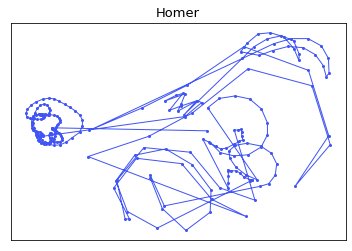

In [170]:
plot("Homer", xs, ys, linestyle="-")